In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt

# Based on https://towardsdatascience.com/building-a-convolutional-neural-network-from-scratch-using-numpy-a22808a00a40

def _overlapping_patch_generator(image_batch, kernel_size):
    batch_size, image_h, image_w = image_batch.shape
    for h in range(image_h - kernel_size + 1):
        for w in range(image_w - kernel_size + 1):
            patch = image_batch[
                :, h : (h + kernel_size), w : (w + kernel_size)
            ]
            yield patch, h, w
    

class JankAI_Conv2d(nn.Module):
    def __init__(self, kernel_num, kernel_size):
        super().__init__()
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        kernels = torch.Tensor(kernel_num, kernel_size, kernel_size)
        nn.init.normal_(kernels, mean=0.0, std=1.0 / (kernel_size**2))
        # Wrap in nn.Parameter to let PyTorch know it needs updating
        self.kernels = nn.Parameter(kernels)

    def forward(self, x):
        batch_size,  image_h, image_w = x.shape
        conv_output = torch.zeros([
            batch_size,
            self.kernel_num,
            image_h - self.kernel_size + 1,
            image_w - self.kernel_size + 1,
        ], device=x.device)
        for patch, h, w in _overlapping_patch_generator(x, self.kernel_size):
            assert patch.shape == (batch_size, self.kernel_size, self.kernel_size)
            assert self.kernels.shape == (self.kernel_num, self.kernel_size, self.kernel_size)
            patch = torch.unsqueeze(patch, dim=1)
            # patch.shape == (batch_size, 1, self.kernel_size, self.kernel_size)
            # self.kernel.shape == (self.kernel_num, self.kernel_size, self.kernel_size)
            # So multiplication broadcasts over batch_size and kernel_num
            mult = patch * self.kernels
            assert mult.shape == (batch_size, self.kernel_num, self.kernel_size, self.kernel_size)
            convolved = mult.sum(dim=(2, 3))
            # Alternatively convolved = torch.einsum('bhw,khw->bk', patch, self.kernels)
            # convolved_(i, j) is a patch (with top right coords (h, w)) of image_i convolved with kernel_j
            assert convolved.shape == (batch_size, self.kernel_num)
            conv_output[:, :, h, w] = convolved
        return conv_output

    
# Following the recipe of https://pytorch.org/docs/stable/notes/extending.html
class JankAI_Conv2dFunction(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, image_batch, kernels):
        ctx.save_for_backward(image_batch, kernels)
        batch_size,  image_h, image_w = image_batch.shape
        kernel_num, kernel_h, kernel_w = kernels.shape
        assert kernel_h == kernel_w
        conv_output = torch.zeros([
            batch_size,
            kernel_num,
            image_h - kernel_h + 1,
            image_w - kernel_w + 1,
        ], device=image_batch.device)
        for patch, h, w in _overlapping_patch_generator(image_batch, kernel_w):
            conv_output[:, :, h, w] = torch.einsum('bhw,khw->bk', patch, kernels)
        return conv_output
    
    @staticmethod
    def backward(ctx, grad_output):
        image_batch, kernels = ctx.saved_tensors
        grad_image_batch = grad_kernels = None
        
        kernel_num, kernel_h, kernel_w = kernels.shape
        
        def _compute_grad_image_batch():
            grad_image_batch = torch.zeros(image_batch.shape, device=image_batch.device)
            
            for patch, h, w in _overlapping_patch_generator(image_batch, kernel_w):
                grad_image_batch[:, h:h+(kernel_h), w:(w+kernel_w)] += torch.einsum('khw,bk->bhw', kernels, grad_output[:, :, h, w])
            
            return grad_image_batch

        def _compute_grad_kernels():
            grad_kernels = torch.zeros(kernels.shape, device=kernels.device)
            
            for patch, h, w in _overlapping_patch_generator(image_batch, kernel_w):
                grad_kernels += torch.einsum('bhw,bk->khw', patch, grad_output[:,:,h,w])

            return grad_kernels
        
        if ctx.needs_input_grad[0]:
            grad_image_batch = _compute_grad_image_batch()
        if ctx.needs_input_grad[1]:
            grad_kernels = _compute_grad_kernels()
        
        return grad_image_batch, grad_kernels
    
class JankAI_Conv2dMk2(nn.Module):
    def __init__(self, kernel_num, kernel_size):
        super().__init__()
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        kernels = torch.Tensor(kernel_num, kernel_size, kernel_size)
        nn.init.normal_(kernels, mean=0.0, std=1.0 / (kernel_size**2))
        # Wrap in nn.Parameter to let PyTorch know it needs updating
        self.kernels = nn.Parameter(kernels)
        
    def forward(self, x):
        return JankAI_Conv2dFunction.apply(x, self.kernels)
    
def _distinct_patch_generator(image_batch, kernel_size):
    batch_size, n_channels, image_h, image_w = image_batch.shape
    output_h = image_h // kernel_size
    output_w = image_w // kernel_size
    for h in range(output_h):
        for w in range(output_w):
            start_h = h * kernel_size
            end_h = start_h + kernel_size
            start_w = w * kernel_size
            end_w = start_w + kernel_size
            patch = image_batch[:, :, start_h:end_h, start_w:end_w]
            yield patch, h, w
    
class JankAI_MaxPooling(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
    
    def forward(self, x):
        batch_size, n_channels, image_h, image_w = x.shape
        output_h = image_h // self.kernel_size
        output_w = image_w // self.kernel_size
        output = torch.zeros([
            batch_size, n_channels, output_h, output_w
        ], device=x.device)
        for patch, h, w in _distinct_patch_generator(x, self.kernel_size):
             output[:,:, h, w] = torch.amax(patch, dim=(2, 3))
        return output

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class TomNet(nn.Module):
    def __init__(self):
        super(TomNet, self).__init__()
        self.conv1 = JankAI_Conv2dMk2(10, kernel_size=5)
        #self.conv1 = JankAI_Conv2d(10, kernel_size=5)
        # (28x28) gets convolved down to (24x24) x 10 channels
        self.pooling = JankAI_MaxPooling(4)
        # Then max pooling drops down to (6x6) x 10 channels
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(6 * 6 * 10, 10)
        # Want 10 outputs
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.squeeze()
        x = F.relu(self.conv1(x))
        x = self.pooling(x)
        x = x.view(-1, 6 * 6 * 10)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.log_softmax(x)
        return x


In [4]:
network = TomNet()
network= network.cuda()
network

TomNet(
  (conv1): JankAI_Conv2dMk2()
  (pooling): JankAI_MaxPooling()
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=360, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [5]:
train_batch_size=32
test_batch_size=1000
n_epochs = 10
log_interval = 100

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        train=True,
        root="./data",
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=train_batch_size,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        train=False,
        root="./data",
        download=True,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=test_batch_size,
)

optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

In [6]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target, reduction="mean")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            percentage_complete = 100.0 * batch_idx/len(train_loader)
            print(
                f"Epoch {epoch} ({percentage_complete:.2f}%)\tLoss:{loss.item():.6f}"
            )


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction="mean").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    accuracy_percentage = 100.0 * correct / len(test_loader.dataset)
    print(
        f"\nTest set: Avg. loss: {test_loss:.6f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy_percentage:.2f}%)\n"
    )


/home/tom/.local/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


ℙ(0)=0.10161   ℙ(1)=0.09936   ℙ(2)=0.10291   ℙ(3)=0.10009   ℙ(4)=0.10050   ℙ(5)=0.10258   ℙ(6)=0.10403   ℙ(7)=0.09721   ℙ(8)=0.09903   ℙ(9)=0.09268   

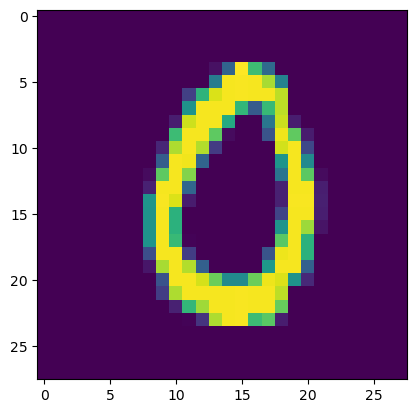

In [7]:
network.eval()
for idx, (data, target) in enumerate(test_loader):
    if idx == 1:
        out_data = data.to(device)
        out_target = target.to(device)
        out_pred = network(out_data)
sample_idx = 1
plt.imshow(out_data[sample_idx,:,:].cpu().squeeze())
prediction = torch.exp(out_pred[sample_idx,:]).cpu()
for idx, prob in enumerate(prediction.tolist()):
    print(f"ℙ({idx})={prob:.5f}", end = "   ")

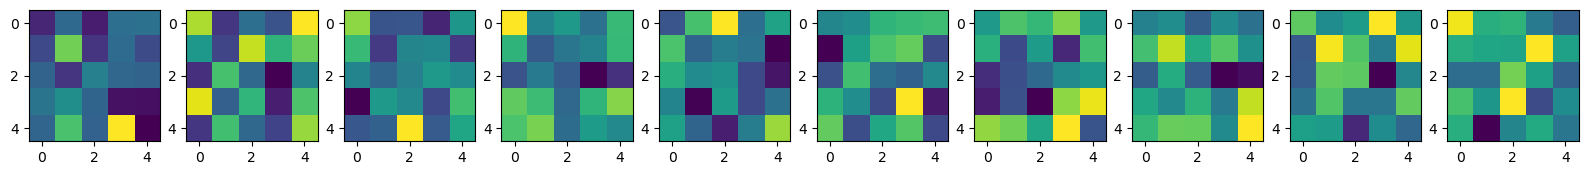

In [8]:
fig, ax = plt.subplots(1,10, figsize=(20, 200))
for i in range(10):
    ax[i].imshow(network.conv1.kernels[i,:,:].cpu().detach().squeeze())

In [9]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.002294, Accuracy: 1247/10000 (12.47%)

Epoch 1 (0.00%)	Loss:2.311008
Epoch 1 (5.33%)	Loss:2.144072
Epoch 1 (10.67%)	Loss:1.367838
Epoch 1 (16.00%)	Loss:0.869619
Epoch 1 (21.33%)	Loss:0.911398
Epoch 1 (26.67%)	Loss:1.100908
Epoch 1 (32.00%)	Loss:0.750600
Epoch 1 (37.33%)	Loss:0.683802
Epoch 1 (42.67%)	Loss:0.517257
Epoch 1 (48.00%)	Loss:0.441677
Epoch 1 (53.33%)	Loss:0.597743
Epoch 1 (58.67%)	Loss:0.333909
Epoch 1 (64.00%)	Loss:0.611396
Epoch 1 (69.33%)	Loss:0.566543
Epoch 1 (74.67%)	Loss:0.309470
Epoch 1 (80.00%)	Loss:0.388157
Epoch 1 (85.33%)	Loss:0.351488
Epoch 1 (90.67%)	Loss:0.462379
Epoch 1 (96.00%)	Loss:0.532409

Test set: Avg. loss: 0.000249, Accuracy: 9310/10000 (93.10%)

Epoch 2 (0.00%)	Loss:0.476010
Epoch 2 (5.33%)	Loss:0.300082
Epoch 2 (10.67%)	Loss:0.455493
Epoch 2 (16.00%)	Loss:0.597797
Epoch 2 (21.33%)	Loss:0.215276
Epoch 2 (26.67%)	Loss:0.591990
Epoch 2 (32.00%)	Loss:0.238510
Epoch 2 (37.33%)	Loss:0.278171
Epoch 2 (42.67%)	Loss:0.348311
Epoch 2 (4

ℙ(0)=0.99648   ℙ(1)=0.00000   ℙ(2)=0.00015   ℙ(3)=0.00000   ℙ(4)=0.00003   ℙ(5)=0.00003   ℙ(6)=0.00258   ℙ(7)=0.00000   ℙ(8)=0.00056   ℙ(9)=0.00016   

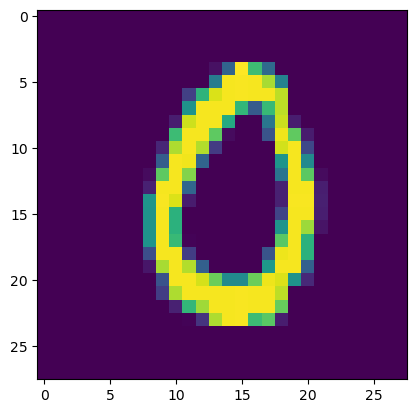

In [10]:
network.eval()
for idx, (data, target) in enumerate(test_loader):
    if idx == 1:
        out_data = data.to(device)
        out_target = target.to(device)
        out_pred = network(out_data)
sample_idx = 1
plt.imshow(out_data[sample_idx,:,:].cpu().squeeze())
prediction = torch.exp(out_pred[sample_idx,:]).cpu()
for idx, prob in enumerate(prediction.tolist()):
    print(f"ℙ({idx})={prob:.5f}", end = "   ")

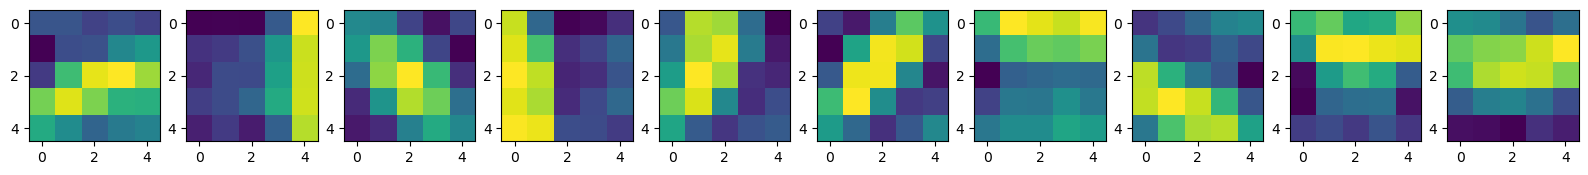

In [11]:
fig, ax = plt.subplots(1,10, figsize=(20, 200))
for i in range(10):
    ax[i].imshow(network.conv1.kernels[i,:,:].cpu().detach().squeeze())

In [12]:
print(network.conv1.kernels.shape)
print(network.fc1.weight.shape)

torch.Size([10, 5, 5])
torch.Size([10, 360])
